### Agentic RAG

In [44]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [45]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",model_kwargs={'device': 'cpu'})

In [46]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs


[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/how-tos/map-reduce/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')]]

In [47]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=embeddings
)


retriever=vectorstore.as_retriever()

In [48]:
retriever.invoke("what is langgraph")

[Document(id='ed648950-d501-459e-b562-904961868f33', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='Redirecting...\n\n\n\n\n\n\nRedirecting...'),
 Document(id='b7f89e71-e775-400c-b405-a696767623cc', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Redirecting...', 'language': 'en'}, page_content='Redirecting...\n\n\n\n\n\n\nRedirecting...'),
 Document(id='debdecda-906c-45c4-8ec4-98ae865e0614', metadata={'source': 'https://langchain-ai.github.io/langgraph/how-tos/map-reduce/', 'title': 'Redirecting...', 'language': 'en'}, page_content='Redirecting...\n\n\n\n\n\n\nRedirecting...')]

In [ ]:
from langchain_core.tools import Tool

# Tự định nghĩa hàm này (khỏi lo LangChain đổi chỗ)
def create_retriever_tool(retriever, name: str, description: str):
    """Tạo tool tìm kiếm từ Retriever"""
    return Tool(
        name=name,
        description=description,
        func=retriever.invoke # Hoặc dùng retriever.get_relevant_documents cho bản cũ
    )

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about Langgraph"
)

In [50]:
retriever_tool

Tool(name='retriever_vector_db_blog', description='Search and run information about Langgraph', func=<bound method BaseRetriever.invoke of VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000017E3D5E08D0>, search_kwargs={})>)

### Langchain Blogs- Seperate Vector Store


In [51]:
langchain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

docs=[WebBaseLoader(url).load() for url in langchain_urls]
docs

[[Document(metadata={'source': 'https://python.langchain.com/docs/tutorials/', 'title': 'LangChain overview - Docs by LangChain', 'description': 'LangChain is an open source framework with a pre-built agent architecture and integrations for any model or tool — so you can build agents that adapt as fast as the ecosystem evolves', 'language': 'en'}, page_content='LangChain overview - Docs by LangChainSkip to main contentDocs by LangChain home pageLangChain + LangGraphSearch...⌘KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangChain overviewLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewGet startedInstallQuickstartChangelogPhilosophyCore componentsAgentsModelsMessagesToolsShort-term memoryStreamingStructured outputMiddlewareOverviewBuilt-in middlewareCustom middlewareAdvanced usageGuardrailsRuntimeContext engineeringModel Context Protocol (MCP)Human-in-the-loopMulti-agentRetrievalLong-term memoryAgent developmentLangSmith StudioTestAgent Chat UI

In [52]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstorelangchain=FAISS.from_documents(
    documents=doc_splits,
    embedding=embeddings
)


retrieverlangchain=vectorstorelangchain.as_retriever()

In [53]:
from langchain_core.tools import Tool

def create_retriever_tool(retriever, name: str, description: str):
    """Tạo tool tìm kiếm từ Retriever"""
    return Tool(
        name=name,
        description=description,
        func=retriever.invoke 
    )


retriever_tool = create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about Langgraph"
)
tools=[retriever_tool]

### LangGraph Workflow

In [54]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [55]:
from langchain_groq import ChatGroq

model = ChatGroq(model="llama-3.3-70b-versatile")
model.invoke("Hi")

AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.052261063, 'completion_tokens_details': None, 'prompt_time': 0.003751271, 'prompt_tokens_details': None, 'queue_time': 0.052822429, 'total_time': 0.056012334}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bfd28-d313-76c3-bae8-06798398a257-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})

In [56]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="llama-3.3-70b-versatile")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [ ]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchainhub import Client
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field
hub = Client()

In [66]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGroq(model="llama-3.3-70b-versatile")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [76]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq

def generate(state):
    """
    Generate answer
    Args:
        state (messages): The current state
    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    # Giả định bước trước đó (Retrieve) đã trả về nội dung documents vào message cuối
    docs = last_message.content

    # 1. ĐỊNH NGHĨA PROMPT (Thay thế cho hub.pull để tránh lỗi)
    # Chúng ta dùng ChatPromptTemplate mà bạn đã import
    template_text = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    
    Question: {question} 
    Context: {context} 
    Answer:"""
    
    prompt = ChatPromptTemplate.from_template(template_text)

    # 2. LLM (Model bạn chọn đã chuẩn)
    model = ChatGroq(model="llama-3.3-70b-versatile")

    # 3. Chain
    # Lưu ý: docs ở đây đã là string rồi nên không cần hàm format_docs nữa
    rag_chain = prompt | model | StrOutputParser()

    # 4. Run
    response = rag_chain.invoke({"context": docs, "question": question})
    
    return {"messages": [response]}

In [77]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="llama-3.3-70b-versatile")
    response = model.invoke(msg)
    return {"messages": [response]}

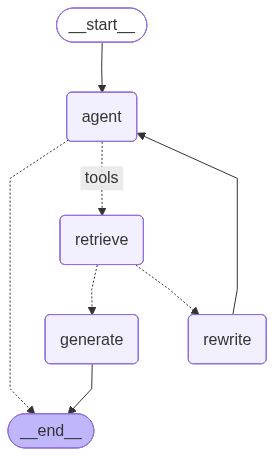

In [78]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [79]:
graph.invoke({"messages":"What is Langgraph?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langgraph?', additional_kwargs={}, response_metadata={}, id='009f4c29-67fc-4566-bfdc-1cff3ea58570'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ghz3qzn6z', 'function': {'arguments': '{"__arg1":"Langgraph"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 237, 'total_tokens': 258, 'completion_time': 0.049482799, 'completion_tokens_details': None, 'prompt_time': 0.011660151, 'prompt_tokens_details': None, 'queue_time': 0.053559691, 'total_time': 0.06114295}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bfd2e-5f3b-7063-b584-0af4c854dafa-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'__arg1': 'Langgraph'}, 'id': 'ghz3qzn6z', 'type': 'tool_call'}], invalid_tool_calls=[

In [80]:
graph.invoke({"messages":"What is Langchain?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langchain?', additional_kwargs={}, response_metadata={}, id='5da699b8-6994-4e25-b472-f89b95041c8e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mg9w7cktr', 'function': {'arguments': '{"__arg1":"Langchain"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 237, 'total_tokens': 258, 'completion_time': 0.048416455, 'completion_tokens_details': None, 'prompt_time': 0.011918067, 'prompt_tokens_details': None, 'queue_time': 0.052510093, 'total_time': 0.060334522}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bfd2e-73a4-79b1-864b-8b7a37d1b91c-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'__arg1': 'Langchain'}, 'id': 'mg9w7cktr', 'type': 'tool_call'}], invalid_tool_calls=

In [81]:
graph.invoke({"messages":"What is Machine learning?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is Machine learning?', additional_kwargs={}, response_metadata={}, id='8fc94987-c79d-43b2-aedd-ed29813da02c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'txm7s7hpk', 'function': {'arguments': '{"__arg1":"Machine learning definition"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 237, 'total_tokens': 259, 'completion_time': 0.059364918, 'completion_tokens_details': None, 'prompt_time': 0.011329446, 'prompt_tokens_details': None, 'queue_time': 0.051697214, 'total_time': 0.070694364}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bfd2e-814b-7f43-bf7e-8f4af6e614ab-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'__arg1': 'Machine learning definition'}, 'id': 'txm7s7hpk',